In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 학습 및 테스트용 CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Class 개수와 이미지 크기 지정
NUM_CLASSES = 10            # CIFAR-10 Dataset 은 10개의 class 를 가지고 있음
IMG_HEIGHT = 32             # CIFAR-10 Dataset 의 이미지 크기 32x32x3
IMG_WIDTH = 32

# Epoch 횟수와 batch size, learning rate, dropout ratio 지정
EPOCHS = 30                 # 학습 반복 횟수 지정
BATCH_SIZE = 32             # 학습에 사용할 mini-batch 크기
LEARNING_RATE = 0.0001      # Optimizer 에 사용할 learning rate
DROP_OUT_RATIO = 0.5        # AlexNet 에 사용된 Dropout 비율

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [3]:
# One-hot encoding 형태로 label 데이터 변경
print('ex) y_train[0]=', y_train[0])

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print('ex) after one-hot conversion, y_train[0]=', y_train[0])
print('y_train.shape= ', y_train.shape, ', y_test.shape = ', y_test.shape)

# ImageDataGenerator pipeline 을 이용한 Data augmentation
datagen = ImageDataGenerator(
            rescale=1./255.,         # 데이터 정규화([0,255] -> [0.0,1.0])
            rotation_range=30,       # random rotation
            horizontal_flip=True,    # random horizontal flip
            validation_split=0.2)    # validation 에 사용할 데이터 비율(20%)


(50000, 10) (10000, 10)


In [4]:
def AlexNet_cifar10():
    model = tf.keras.Sequential([
        #layer 1
        # 첫 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 3-channels
        # Output channel : 96-channels
        # Stride : 1
        # Activation : ReLU
        tf.keras.layers.Conv2D(filters=96,
                              kernel_size=(3, 3),
                              strides=1,
                              padding='same',
                              activation=tf.keras.activations.relu,
                              input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Overlapped Pooling
        # Window size : 3x3
        # Stride : 2
        tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                 strides=2,
                                 padding='same'),
        # Batch Normalization
        tf.keras.layers.BatchNormalization(),

        #layer 2
        # 두 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 96-channels
        # Output channel : 256-channels
        # Stride : 1
        # Activation : ReLU
        tf.keras.layers.Conv2D(filters=256,
                              kernel_size=(3, 3),
                              strides=1,
                              padding='same',
                              activation=tf.keras.activations.relu),
        # Overlapped Pooling
        # Window size : 3x3
        # Stride : 2
        tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                 strides=2,
                                 padding='same'),
        # Batch Normalization
        tf.keras.layers.BatchNormalization(),
        
        #layer 3
        # 세 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 256-channels
        # Output channel : 384-channels
        # Stride : 1
        # Activation : ReLU
        tf.keras.layers.Conv2D(filters=384,
                              kernel_size=(3, 3),
                              strides=1,
                              padding='same',
                              activation=tf.keras.activations.relu),
        
        #layer 4
        # 네 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 384-channels
        # Output channel : 384-channels
        # Stride : 1
        # Activation : ReLU        
        tf.keras.layers.Conv2D(filters=384,
                              kernel_size=(3, 3),
                              strides=1,
                              padding='same',
                              activation=tf.keras.activations.relu),
        
        #layer 5
        # 다섯 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 384-channels
        # Output channel : 256-channels
        # Stride : 1
        # Activation : ReLU 
        tf.keras.layers.Conv2D(filters=256,
                              kernel_size=(3, 3),
                              strides=1,
                              padding='same',
                              activation=tf.keras.activations.relu),
        # Overlapped Pooling
        # Window size : 3x3
        # Stride : 2
        tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                 strides=2,
                                 padding='same'),
        # Batch Normalization
        tf.keras.layers.BatchNormalization(),
        
        #layer 6
        # Flatten() : (Batch, Height, Width, Channel) -> (Batch, Height*Width*Channel)
        tf.keras.layers.Flatten(),
        # Dense Layer
        # Input Units : Height*Width*Channel
        # Output Units : 4096
        # Activation : ReLU
        tf.keras.layers.Dense(units=4096,
                             activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(rate=DROP_OUT_RATIO),
        
        #layer 7
        # Dense Layer
        # Input Units : 4096
        # Output Units : 4096
        # Activation : ReLU
        tf.keras.layers.Dense(units=4096,
                             activation=tf.keras.activations.relu),
        # Dropout
        tf.keras.layers.Dropout(rate=DROP_OUT_RATIO),
        
        #layer 8
        # Dense Layer
        # Input Units : 4096
        # Output Units : NUM_CLASSES(CIFAR-10 : 10)
        # Activation : Softmax
        tf.keras.layers.Dense(units=NUM_CLASSES,
                             activation=tf.keras.activations.softmax)
    ])
    
    return model

In [5]:
# AlexNet 모델 생성
model = AlexNet_cifar10()

# 학습에 사용할 Adam optimizer 및 loss function 생성
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
losses = tf.keras.losses.CategoricalCrossentropy()

# 모델 컴파일(optimizer, loss 지정)
model.compile(optimizer=optimizer,
              loss=losses,
              metrics=['acc'])

In [6]:
# 모델 summary 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       221440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         8

In [7]:
# datagen.flow : 데이터와 레이블 어레이를 가져와서, augmented 데이터 배치를 생성
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='training'),
                    # 학습에 사용할 데이터 : 미리 만들어둔 ImageDataGenerator pipeline에 x_train, y_train 입력하여 사용
                    # subset = 'training' 으로 학습용 데이터라는 것을 pipeline에 알려주어야함
                   validation_data=datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
                    # 검증에 사용할 데이터 : 미리 만들어둔 ImageDataGenerator pipeline에 x_train, y_train 입력하여 사용
                    # subset = 'validation' 으로 검증용 데이터라는 것을 pipeline에 알려주어야함
                    epochs=EPOCHS,              # epoch 횟수 입력
                    shuffle=True)

Epoch 1/30
1250/1250 [==============================] - 21s 16ms/step - loss: 1.5932 - acc: 0.4430 - val_loss: 1.2150 - val_acc: 0.5649
Epoch 2/30
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1811 - acc: 0.5801 - val_loss: 1.0626 - val_acc: 0.6311
Epoch 3/30
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0078 - acc: 0.6450 - val_loss: 0.9056 - val_acc: 0.6800
Epoch 4/30
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9027 - acc: 0.6852 - val_loss: 0.8516 - val_acc: 0.7015
Epoch 5/30
1250/1250 [==============================] - 21s 16ms/step - loss: 0.8162 - acc: 0.7154 - val_loss: 0.8108 - val_acc: 0.7126
Epoch 6/30
1250/1250 [==============================] - 20s 16ms/step - loss: 0.7520 - acc: 0.7398 - val_loss: 0.8225 - val_acc: 0.7123
Epoch 7/30
1250/1250 [==============================] - 21s 17ms/step - loss: 0.7034 - acc: 0.7561 - val_loss: 0.7413 - val_acc: 0.7500
Epoch 8/30
1250/1250 [==========================

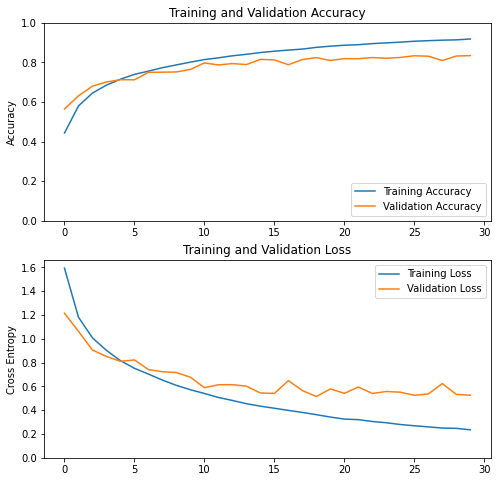

In [8]:
# Training accuracy 및 validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# Training loss 및 validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib 를 이용하여 accuracy 및 loss 출력
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Test 데이터를 이용한 학습 모델 검증
x_test = x_test / 255.0    # 데이터 전처리 과정에서 test data 를 정규화 하지 않았으므로 검증 전 정규화 수행
test_loss, test_acc = model.evaluate(x_test, y_test,
          batch_size=1, verbose=1)
print('Test Loss : {:.4f}, Test Accuracy : {:.2f}%'.format(test_loss, 100.*test_acc))

10000/10000 [==============================] - 31s 3ms/step - loss: 0.5126 - acc: 0.8489
Test Loss : 0.5126, Test Accuracy : 84.89%
